# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_PATH = Path('../data/')

## Options

In [3]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [10]:
n_models = 10
patience = 50
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [11]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [12]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 17.228s 


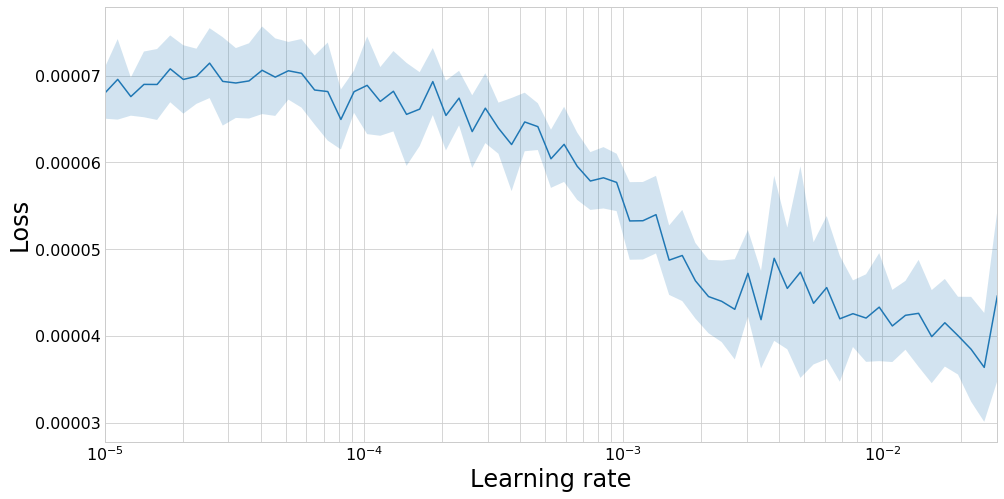

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [13]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
2 classes found, running in binary mode

1 New best found: 3.5378327723388025e-05
2 New best found: 3.3623114236118665e-05
3 New best found: 3.3530581904810354e-05
5 New best found: 3.306108942580297e-05
6 New best found: 3.24050192207065e-05
11 New best found: 3.211471449531065e-05
13 New best found: 3.198555717408607e-05
17 New best found: 3.1692745651178464e-05
22 New best found: 3.165216903452791e-05
26 New best found: 3.146503070661903e-05
47 New best found: 3.138955849847479e-05
50 New best found: 3.12870400757839e-05
53 New best found: 3.121327769439476e-05
81 New best found: 3.121263187593654e-05
Early stopping after 131 epochs
Score is: {'loss': 3.121263187593654e-05, 'wAUC': 0.06060080449540062, 'AUC': 0.09909115324122086, 'AMS': 3.8514753068706273, 'cut': 0.9842957258224487}
Fold took 134.637s

Training model 2 / 10
1 New best found: 3.6118588312820066e-05
2 New best found: 3.512373635312542e-05
3 New best found: 3.351343175745569


______________________________________
Training finished
Cross-validation took 1258.549s 


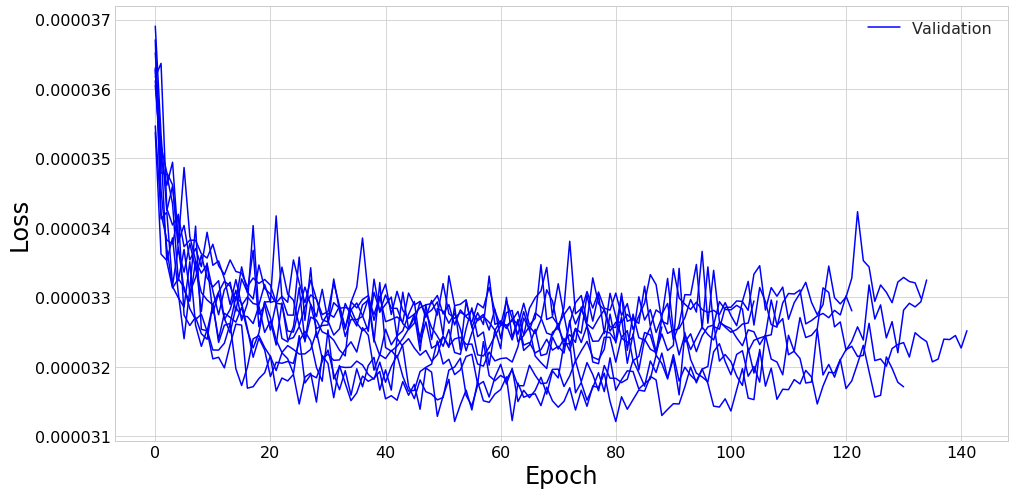

Mean loss = 3.2e-05 +- 1e-07
Mean wAUC = 0.064 +- 0.0006
Mean AUC = 0.1014 +- 0.0006
Mean AMS = 3.74 +- 0.04
Mean cut = 0.951 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [14]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

## Construct ensemble

In [15]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [16]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 0 with loss = 3.121263187593654e-05
Model 1 is 9 with loss = 3.143812445341609e-05
Model 2 is 5 with loss = 3.1595833130355284e-05
Model 3 is 1 with loss = 3.1951677219331035e-05
Model 4 is 3 with loss = 3.195456082612509e-05
Model 5 is 8 with loss = 3.2023751196775e-05
Model 6 is 7 with loss = 3.223145376468892e-05
Model 7 is 4 with loss = 3.228621067735018e-05
Model 8 is 6 with loss = 3.243650298553816e-05
Model 9 is 2 with loss = 3.2539034056221745e-05


## Response on validation data

In [17]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0024150094792246817s per sample

Predicting fold 2 out of 10
Prediction took 0.0003712333284318447s per sample

Predicting fold 3 out of 10
Prediction took 0.0003837659537792206s per sample

Predicting fold 4 out of 10
Prediction took 0.00038708742409944533s per sample

Predicting fold 5 out of 10
Prediction took 0.0003890866853296757s per sample

Predicting fold 6 out of 10
Prediction took 0.0003702541336417198s per sample

Predicting fold 7 out of 10
Prediction took 0.000356949058175087s per sample

Predicting fold 8 out of 10
Prediction took 0.00038609078973531725s per sample

Predicting fold 9 out of 10
Prediction took 0.0003758356116712093s per sample

Predicting fold 10 out of 10
Prediction took 0.0003851849801838398s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9026037538757882, weighted 0.9361149205393235


In [20]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9471648258327816, 0.9637737)

In [21]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9587219024542719, corresponds to calc_ams of 3.8660065271192123
CPU times: user 2.05 s, sys: 15.9 s, total: 17.9 s
Wall time: 2min 15s


(4.0, 0.96)

# Test scoring

In [22]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003696180181747133s per sample

Predicting fold 2 out of 10
Prediction took 0.00038198553960431706s per sample

Predicting fold 3 out of 10
Prediction took 0.0003838120471347462s per sample

Predicting fold 4 out of 10
Prediction took 0.0003784873427992517s per sample

Predicting fold 5 out of 10
Prediction took 0.0003772648010064255s per sample

Predicting fold 6 out of 10
Prediction took 0.00037178910489786755s per sample

Predicting fold 7 out of 10
Prediction took 0.00037058308124542235s per sample

Predicting fold 8 out of 10
Prediction took 0.00037943644455888057s per sample

Predicting fold 9 out of 10
Prediction took 0.0003818429490382021s per sample

Predicting fold 10 out of 10
Prediction took 0.00037651236626234924s per sample

CPU times: user 3min 35s, sys: 22.3 s, total: 3min 58s
Wall time: 3min 27s


In [24]:
score_test_data(test_fy.source, 0.9587219024542719)

Public:Private AMS: 3.6719513775333597 : 3.7099095347422733


(3.6719513775333597, 3.7099095347422733)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)